<a href="https://colab.research.google.com/github/KyryaschiyDeD/AZSII/blob/main/AZSII_Lab_2_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №2
## Выполнил
## Студент группы ББМО-02-23
## Макаров Михаил Максимович

#Задание 1

Текст задания

Обучить 2 классификатора на основе глубоких нейронных сетей на датасете GTSRB. Использовать следующие модели нейронных сетей: VGG16, ResNet50/10X, MobileNet v2/3. Можно использовать фреймворки Keras, TensorFlow, PyTorch, не надо создавать сети вручную и с нуля. Использовать предобученные сети (например на ImageNet). • Выполнить поиск наилучших гиперпараметров моделей. Использовать бесплатные ресурсы GPU сервиса Google Colab. Составить отчёт: (a) Заполнить Таблицу 1. (b) Для каждой модели построить графики функции потерь для данных валидации и тестирования и графики метрики Accuracy(приер на рис. 2).

In [1]:
!pip install adversarial-robustness-toolbox

In [2]:
# импортируем необходимые библиотеки
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

Подключение к диску на котором лежит архив

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Разархивируем датасет, который находится на подключенном диске

In [4]:
zip_file = '/content/drive/MyDrive/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

['.config', 'drive', 'adv_accuracises_pgd_ResNet50.npy', 'Test.csv', 'Train', 'test', 'adv_losses_pgd_ResNet50.npy', 'adv_losses_fgsm_ResNet50.npy', 'Test', 'VGG16.h5', 'adv_accuracises_fgsm_ResNet50.npy', 'ResNet50.h5', 'adv_accuracises_pgd_VGG16.npy', 'Meta', 'adv_accuracises_fgsm_VGG16.npy', 'meta', 'Meta.csv', 'Train.csv', 'adv_losses_pgd_VGG16.npy', 'train', 'adv_losses_fgsm_VGG16.npy', 'sample_data']


Задаем пути к разархивированным данным

In [5]:
data_path = '/content'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

Прочитаем и выполним предварительную обработку изображений из треннировочного набора данных

In [6]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
# отобразим первый элемент
print("data[0]:\n",data[0])

data[0]:
 [[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[0.17254902 0.21176471 0.25490198]
  [0.20392157 0.23137255 0.26666668]
  [0.36078432 0.32156864 0.28627452]
  ...
  [1.         1.         0.972549  ]
  [1.         1.         0.9647059 ]
  [1.         1.         0.9647059 ]]

 [[0.16862746 0.20784314 0.23921569]
  [0.21176471 0.24313726 0.

Отобразим первый элемент в виде картинки

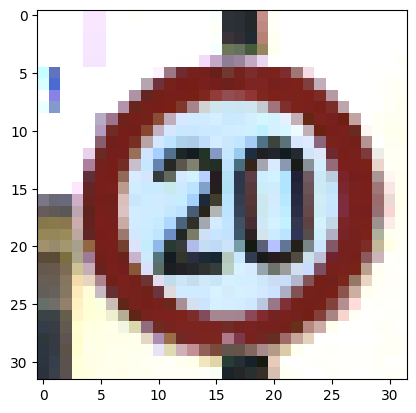

In [7]:
plt.imshow(data[0])

Выполним разделение данных на треннировочный и тестовый набор 70/30

Так же отобразим размерности обучающего и тестового набора и первый элемент

In [8]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Создаем модель глубокого обучения для классификации изображений (ResNet50)

In [9]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False

Обучаем модель в течение 5 эпох, используем оптимизатор Adam и функцию потерь categorical crossentropy

In [10]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 123s 119ms/step - accuracy: 0.5719 - loss: 1.7340 - val_accuracy: 0.2660 - val_loss: 3.1626
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9402 - loss: 0.2111 - val_accuracy: 0.8320 - val_loss: 0.6305
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9626 - loss: 0.1339 - val_accuracy: 0.9288 - val_loss: 0.2483
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9744 - loss: 0.0964 - val_accuracy: 0.8948 - val_loss: 1.4160
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9806 - loss: 0.0777 - val_accuracy: 0.8993 - val_loss: 0.3950


Сохраняем модель для последующего использования

In [11]:
save_model(model, 'ResNet50.h5')

Считаем данные из csv в датафрейм, в ней содержится оригинальная метка класса и путь к изображению

In [12]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

По аналогии с предыдущей, создаем модель для классификации изображений (VGG16)

In [13]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False



Обучаем модель в течение 5 эпох, используем оптимизатор Adam и функцию потерь categorical crossentropy

In [14]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.0841 - loss: 3.4541 - val_accuracy: 0.4073 - val_loss: 1.9167
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.5522 - loss: 1.3230 - val_accuracy: 0.8327 - val_loss: 0.4671
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8597 - loss: 0.4308 - val_accuracy: 0.9129 - val_loss: 0.2720
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9447 - loss: 0.1846 - val_accuracy: 0.9685 - val_loss: 0.1162
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9616 - loss: 0.1429 - val_accuracy: 0.9573 - val_loss: 0.1470


Сохраняем модель для последующего использования

In [15]:
save_model(model2, 'VGG16.h5')

Создаем и выводим таблицу, которая показывает точность обоих моделей на треннировочном, валидационном и тестовом наборе данных

In [16]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history.history['accuracy']

train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
test_accuracy2 = history2.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.9924 |               89.9345 |         97.9924 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             96.4221 |               95.7324 |         96.4221 |
+----------+---------------------+-----------------------+-----------------+


Строим два графика процесса обучения модели ResNet50 графики отражают зависимость метрики от эпохи для тренировочного и тестового наборов

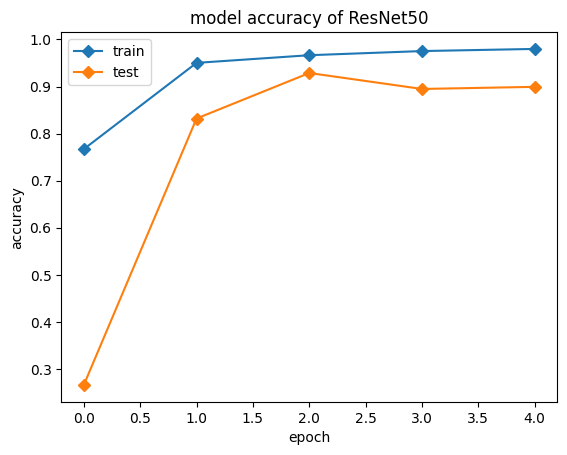

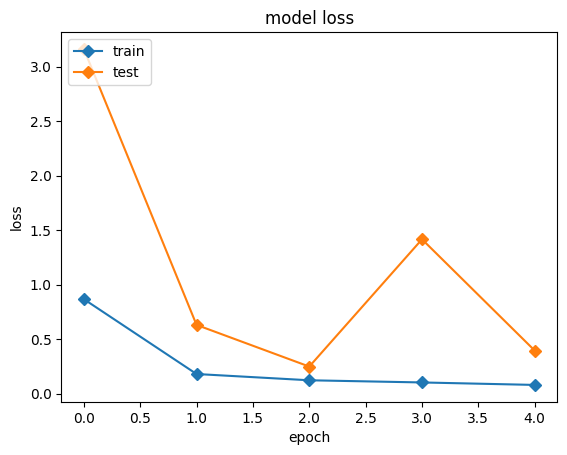

In [17]:
# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Визуализируем процесс обучения модели VGG16 аналогично с предыдущим

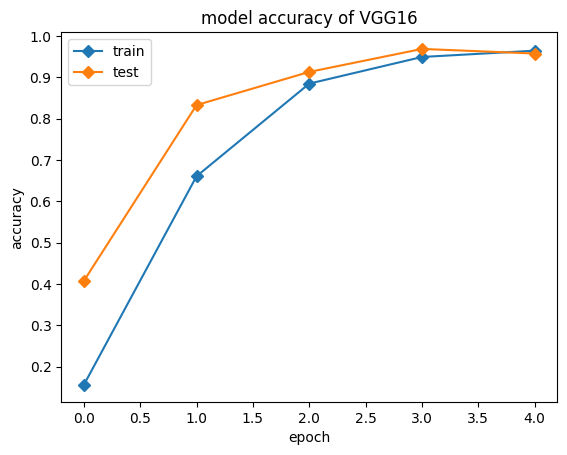

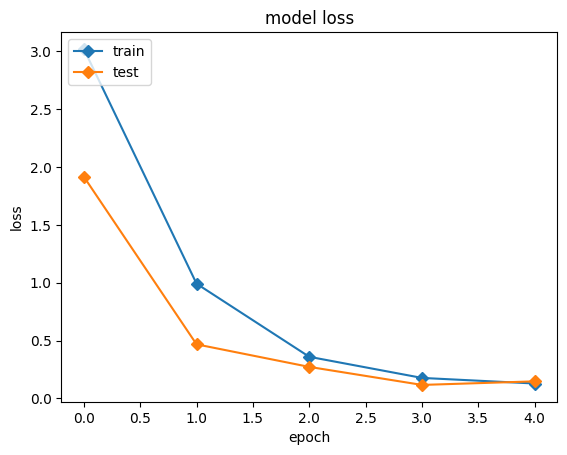

In [18]:
# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Как видно из таблицы, модели показывают приблизительно схожие результаты, немного лучше оказалась модель VGG16 (по валидации)

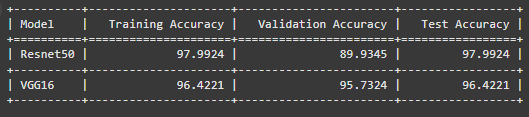

##Задание 2

Загрузим модель из предыдущего задания и берем тысячу первых элементов из тестового множества, создаем классификатор ART

In [19]:
# Устанавливаем библиотеку ART
!pip install adversarial-robustness-toolbox

# Импортируем остальные библиотеки
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np

# Загружаем модель
model = load_model('ResNet50.h5')

# Подготавливаем данные
x_test = data[:1000]
y_test = y_test[:1000]

# Указываем количество классов
nb_classes = len(np.unique(y_test))  # Автоматически определяем количество классов
print("Количество классов:", nb_classes)

# Форма входных данных
input_shape = x_test.shape[1:]  # Используем форму данных, исключая batch size
print("Форма входных данных:", input_shape)

# Создаём классификатор с указанием функции потерь
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=nb_classes,
    input_shape=input_shape,
    clip_values=(np.min(x_test), np.max(x_test)),
    loss_object=SparseCategoricalCrossentropy(from_logits=False)  # Указываем функцию потерь
)

Количество классов: 2
Форма входных данных: (32, 32, 3)


Создаем атаку FGSM

In [20]:
# Создаём атаку FGSM
from art.attacks.evasion import FastGradientMethod
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)

# Диапазон значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

# Списки для сохранения результатов
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

# Проводим атаку для каждого значения eps
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")

    # Генерируем adversarial examples
    x_test_adv = attack_fgsm.generate(x_test, y_test)

    # Оцениваем модель на adversarial examples
    loss, accuracy = model.evaluate(x_test_adv, y_test, verbose=0)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")

    # Оцениваем модель на оригинальных данных
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 2.3363020420074463
Adv Accuracy: 0.6259999871253967
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.00784313725490196
Adv Loss: 3.8333709239959717
Adv Accuracy: 0.4790000021457672
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.011764705882352941
Adv Loss: 4.9329938888549805
Adv Accuracy: 0.3790000081062317
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.01568627450980392
Adv Loss: 5.786324977874756
Adv Accuracy: 0.31200000643730164
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.0196078431372549
Adv Loss: 6.440290451049805
Adv Accuracy: 0.2709999978542328
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.03137254901960784
Adv Loss: 7.640261650085449
Adv Accuracy: 0.1850000023841858
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.0392156862745098
Adv Loss: 8.093125343322754
Adv Accuracy: 0.15700000524520874
True Loss:

Сохраним атаку FGSM для дальнейшего анализа

In [21]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


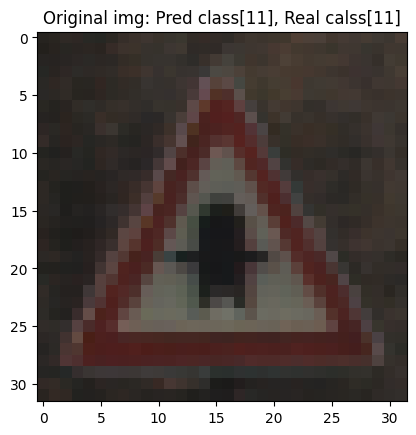

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


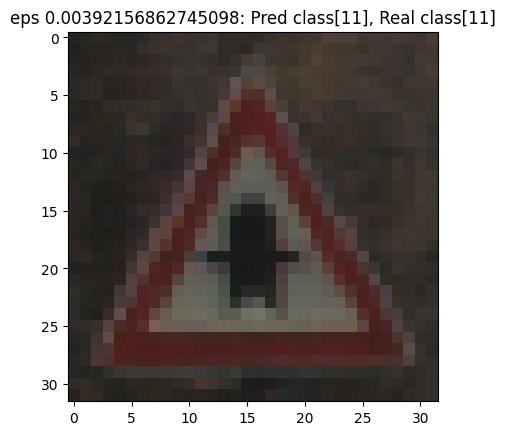

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


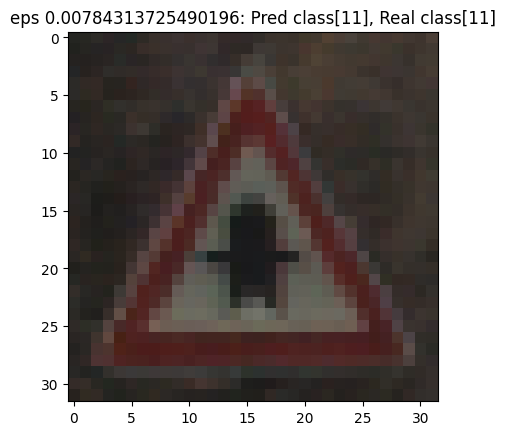

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


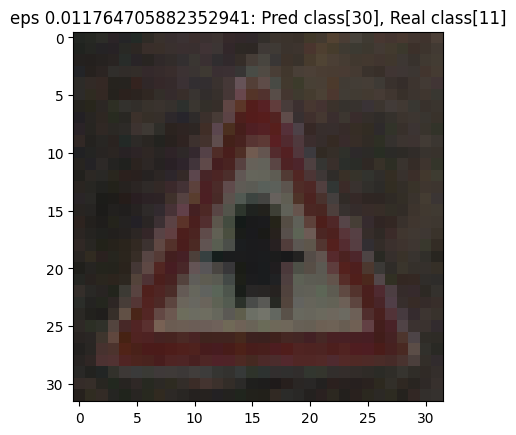

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


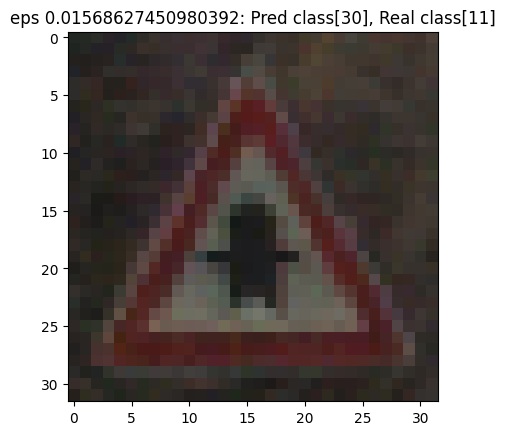

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


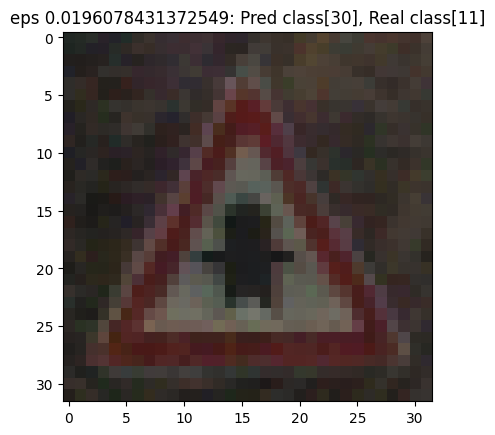

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


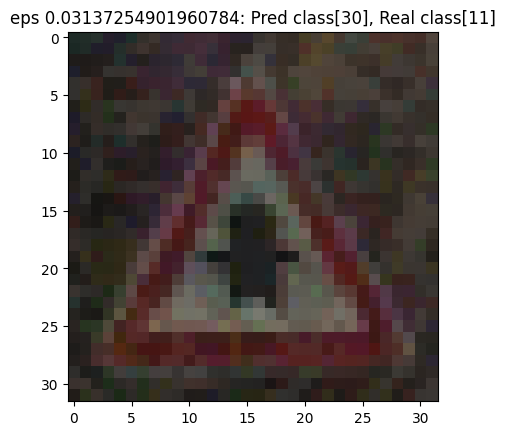

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


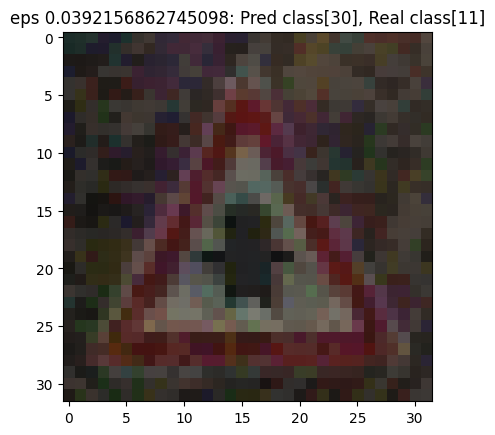

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


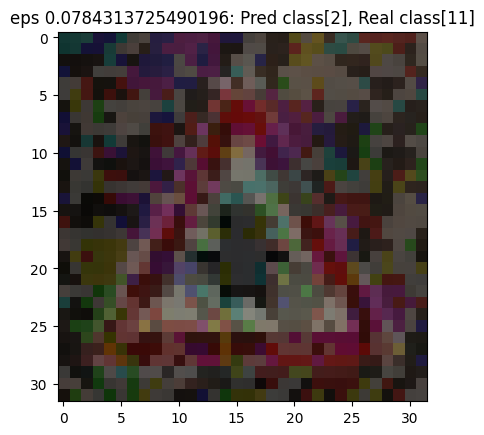

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


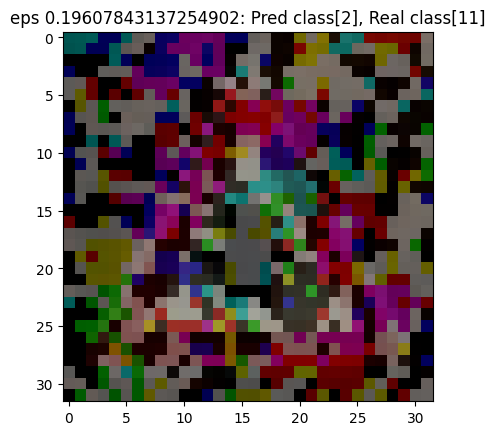

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


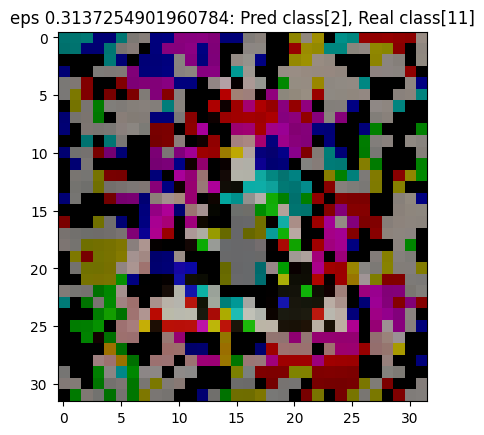

In [22]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Как видно, ошибки предсказания из-за наложенного шума начались со значения 3/255

Теперь реализуем атаку PGD для той же модели, создаем атаку по аналогии с предыдущей

In [23]:
from art.estimators.classification import TensorFlowV2Classifier
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf

# модель
model = load_model('ResNet50.h5')

# данные
x_test = data[:1000]
y_test = y_test[:1000]

# классификатор
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,  #  количество классов
    input_shape=(32, 32, 3),  #  форма входных данных
    clip_values=(np.min(x_test), np.max(x_test)),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

Создаем атаку PGD

In [24]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.6278 - loss: 2.4357
Adv Loss: 2.5876505374908447
Adv Accuracy: 0.6019999980926514
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8259 - loss: 0.7645
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4895 - loss: 3.9773
Adv Loss: 4.228794574737549
Adv Accuracy: 0.4569999873638153
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8259 - loss: 0.7645
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3764 - loss: 4.9350
Adv Loss: 5.28563928604126
Adv Accuracy: 0.36000001430511475
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8259 - loss: 0.7645
True Loss: 0.7940255999565125
True Accuracy: 0.8320000171661377
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3103 - loss: 5.9244
Adv Lo

Сохраним атаку PGD для дальнейшего анализа с помощью графика

In [25]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)


Отображаем исходные и адверсариальные изображения для разных значений eps

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


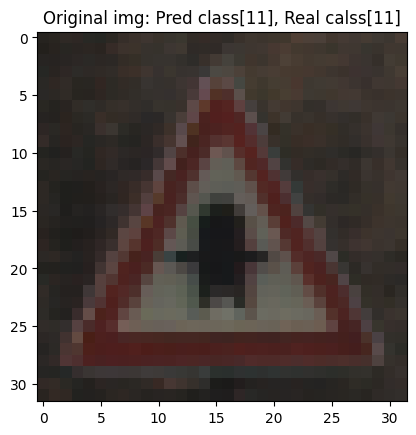

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


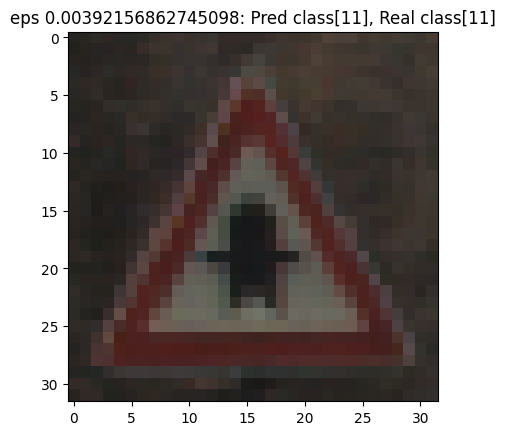

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


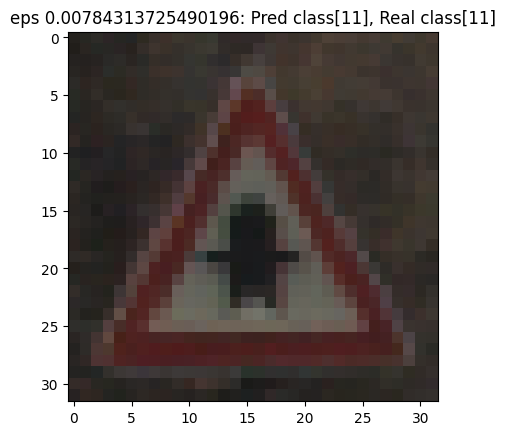

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


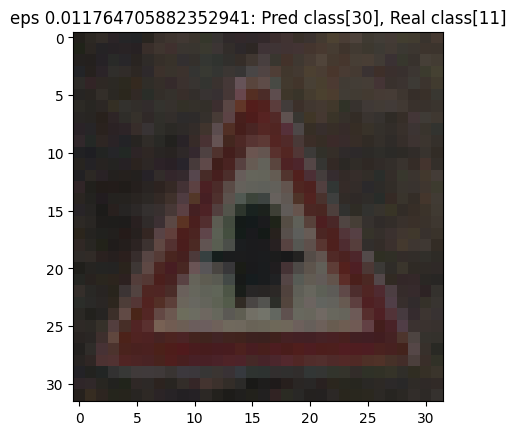

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


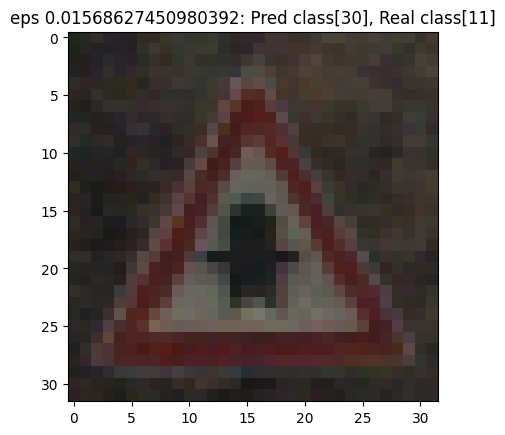

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


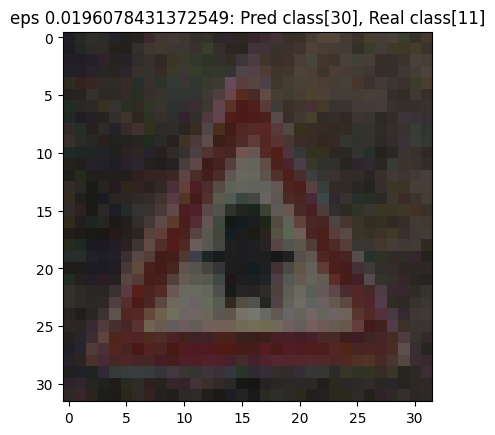

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


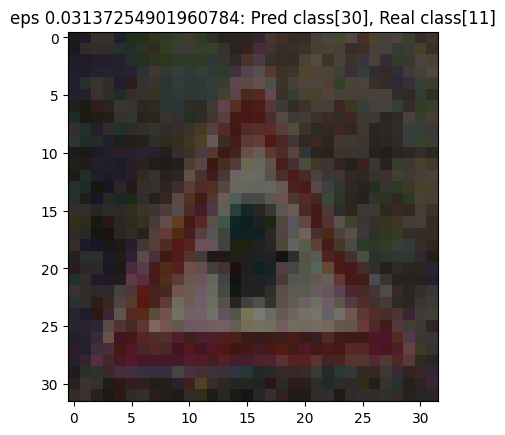

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


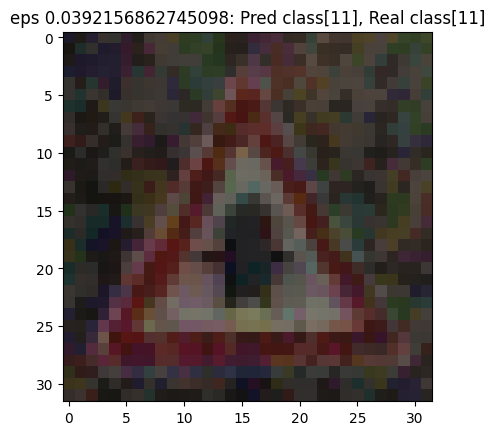

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


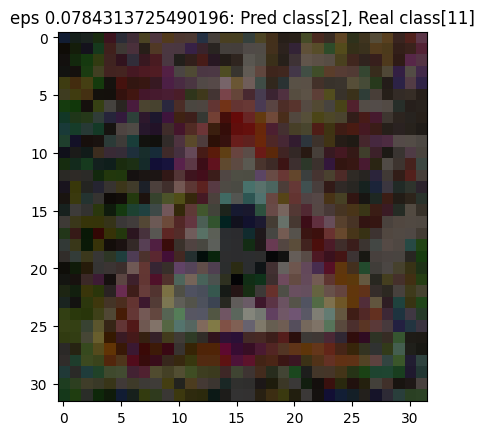

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


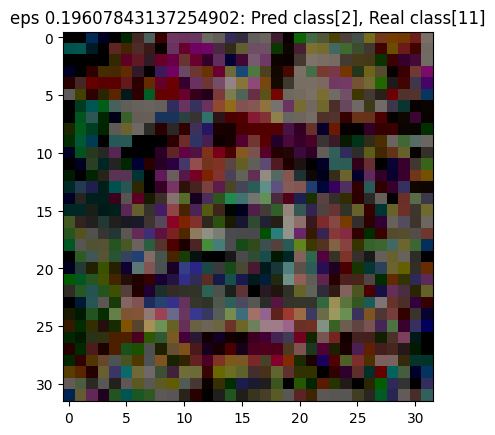

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


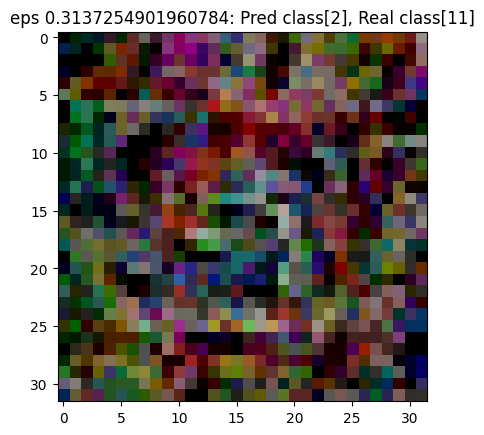

In [26]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Предсказания стали ложными при параметре 3/255

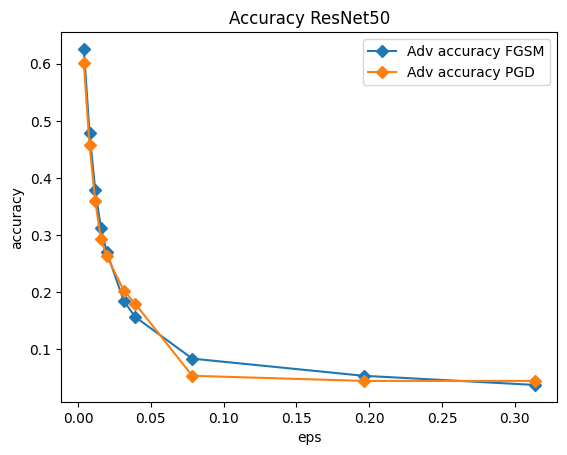

In [27]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Проделаем аналогичные атаки для VGG16 реализуем атаку FGSM для модели VGG16, которую сохраняли в первом задании

In [28]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.models import load_model
import numpy as np

# Включаем eager execution (рекомендуется для TensorFlow 2.x)
tf.config.run_functions_eagerly(True)

# Загружаем модель
model = load_model('VGG16.h5')

# Скомпилируем модель (укажите оптимизатор и функцию потерь)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Подготавливаем данные
x_test = data[:1000]
y_test = y_test[:1000]

# Убедимся, что данные являются массивами NumPy
if isinstance(x_test, tf.data.Dataset):
    x_test = np.array(list(x_test.as_numpy_iterator()))
if isinstance(y_test, tf.data.Dataset):
    y_test = np.array(list(y_test.as_numpy_iterator()))

classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,  # Укажите количество классов
    input_shape=x_test.shape[1:],  # Форма входных данных
    clip_values=(np.min(x_test), np.max(x_test)),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

Создаем атаку FGSM по аналогии с VGG16

In [29]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8125 - loss: 0.8093

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7958 - loss: 1.0288
Adv Loss: 1.0786256790161133
Adv Accuracy: 0.7789999842643738
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6628 - loss: 1.8177
Adv Loss: 1.911110520362854
Adv Accuracy: 0.6470000147819519
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5744 - loss: 2.5973
Adv Loss: 2.684644937515259
Adv Accuracy: 0.5460000038146973
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4798 - loss: 3.1811
Adv Loss: 3.230254650115967
Ad

Сохраним атаку FGSM для дальнейшего анализа с помощью графика

In [30]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


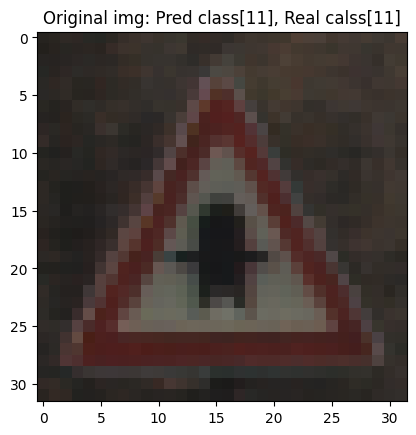

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


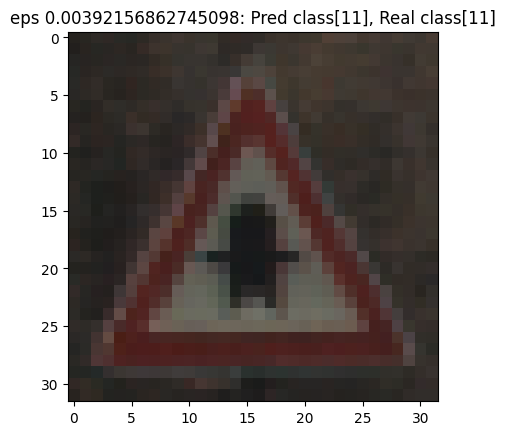

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


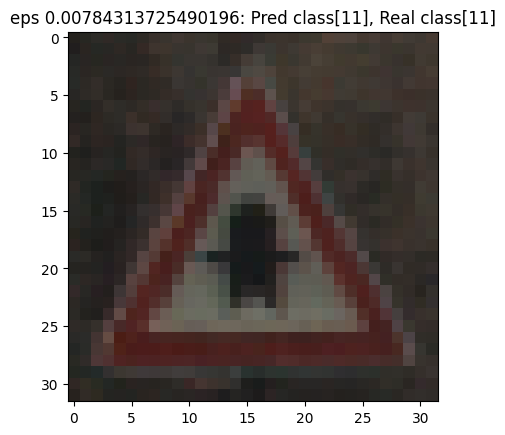

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


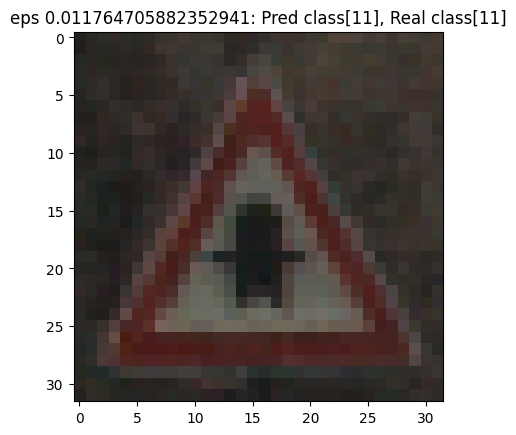

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


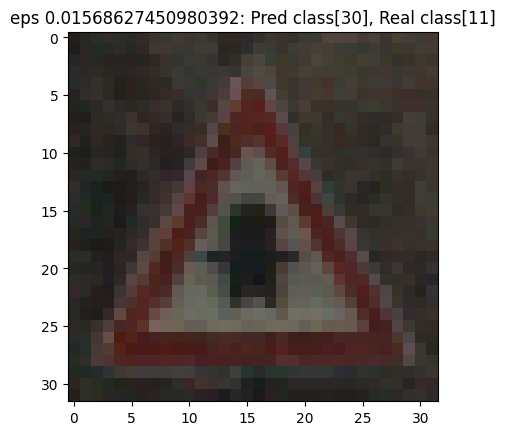

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


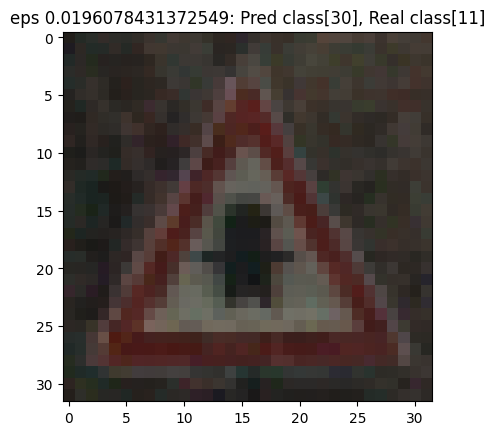

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


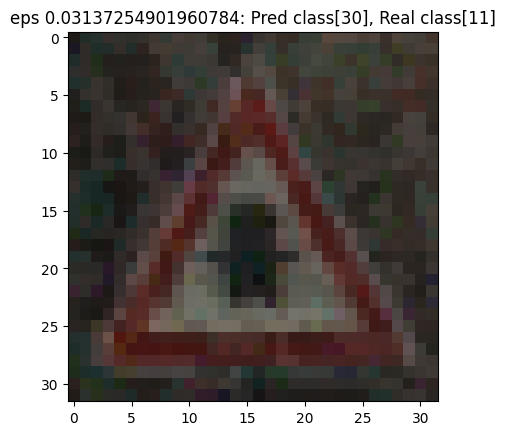

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


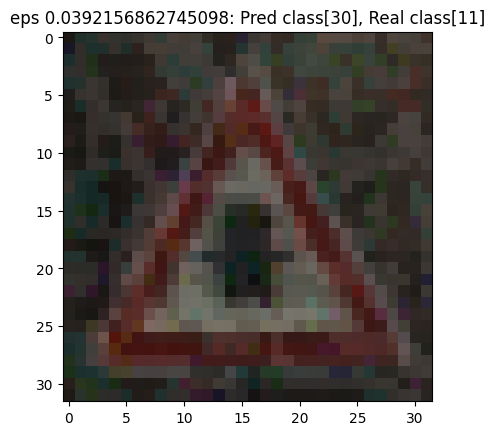

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


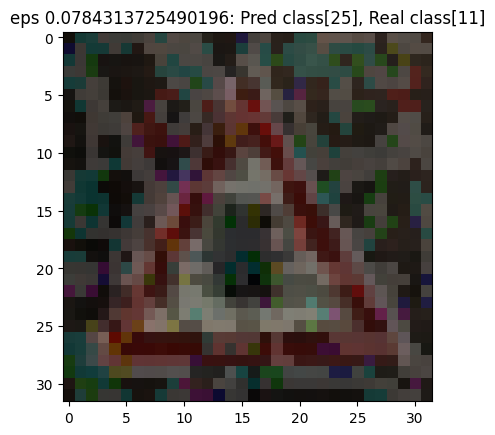

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


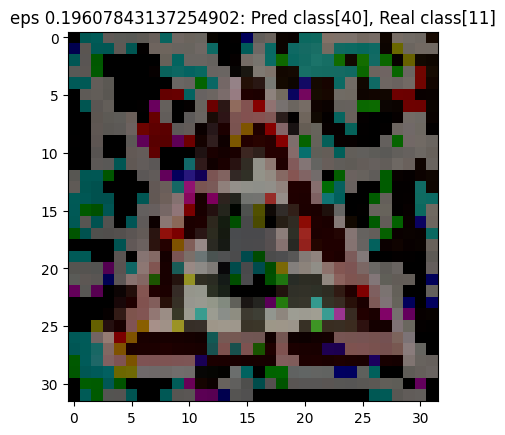

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


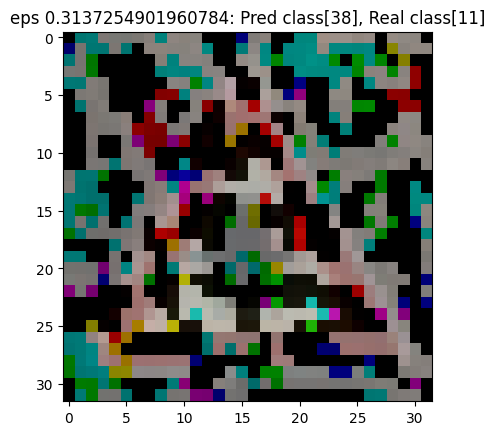

In [31]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Был выдан ложный результат при значении eps 4/255.



Реализуем атаку PGD для модели VGG16

In [32]:
from art.estimators.classification import TensorFlowV2Classifier
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf

# модель
model = load_model('VGG16.h5')

# данные
x_test = data[:1000]
y_test = y_test[:1000]

# классификатор
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,  # количество классов
    input_shape=(32, 32, 3),  # форма входных данных
    clip_values=(np.min(x_test), np.max(x_test)),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

Создаем атаку PGD по аналогии с ResNet50

In [33]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7624 - loss: 1.2250
Adv Loss: 1.283597707748413
Adv Accuracy: 0.7440000176429749
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6165 - loss: 2.2088
Adv Loss: 2.286778450012207
Adv Accuracy: 0.5989999771118164
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5440 - loss: 2.8404
Adv Loss: 2.9154722690582275
Adv Accuracy: 0.5350000262260437
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9014 - loss: 0.3781
True Loss: 0.3883296251296997
True Accuracy: 0.8999999761581421
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4758 - loss: 3.4594
Adv L

Сохраним атаку PGD для дальнейшего анализа с помощью графика

In [34]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

Отображаем исходные и адверсариальные изображения для разных значений eps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


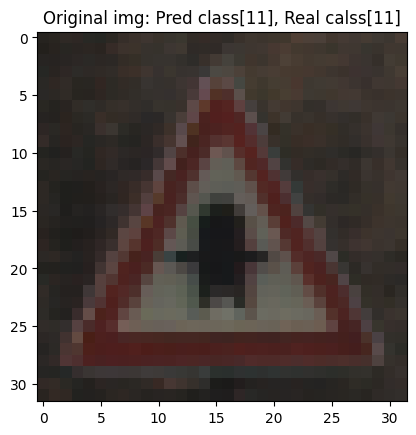

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


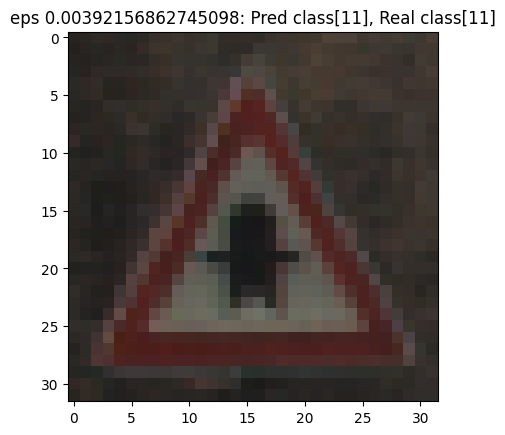

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


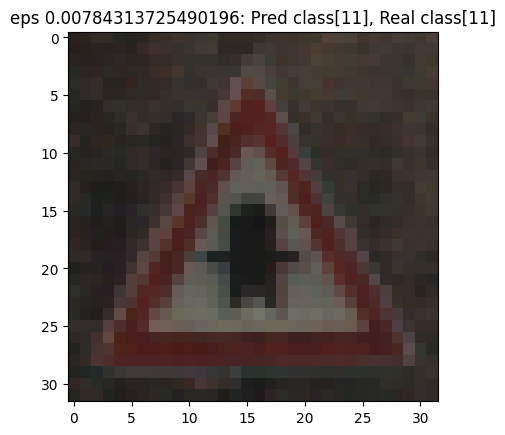

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


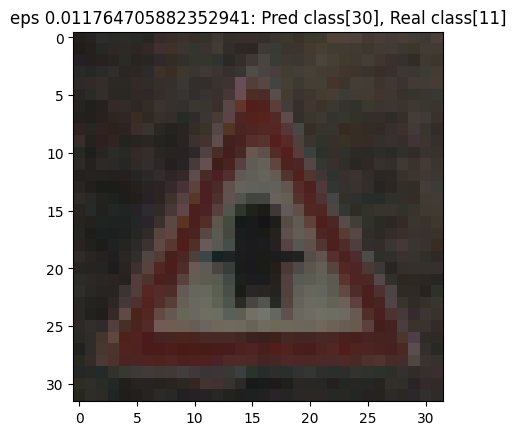

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


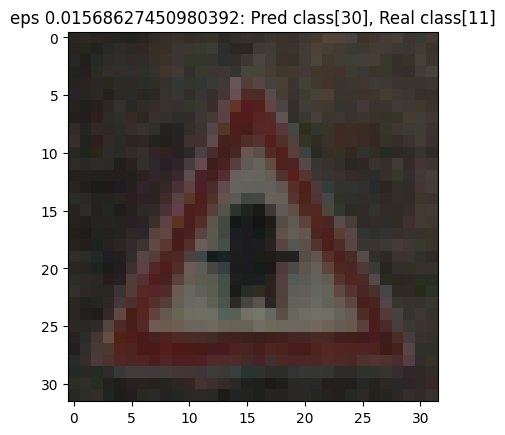

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


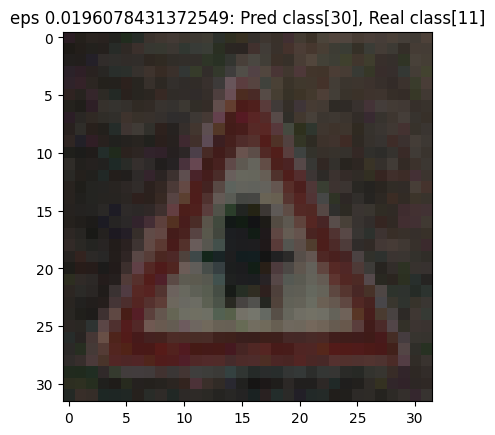

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


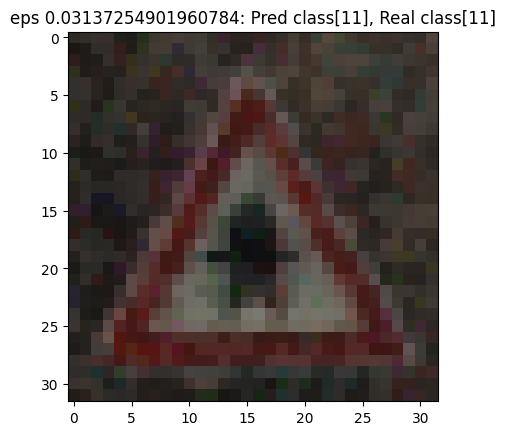

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


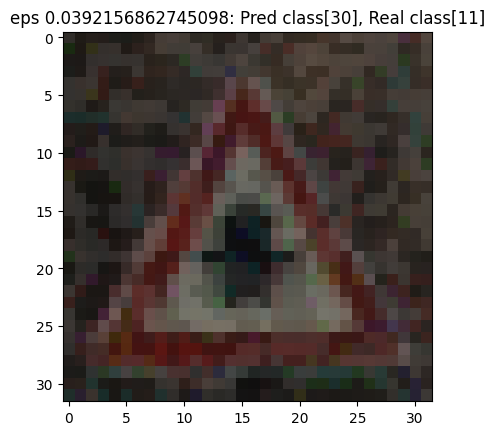

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


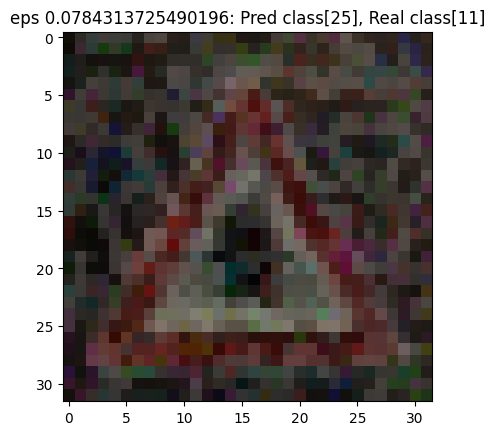

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


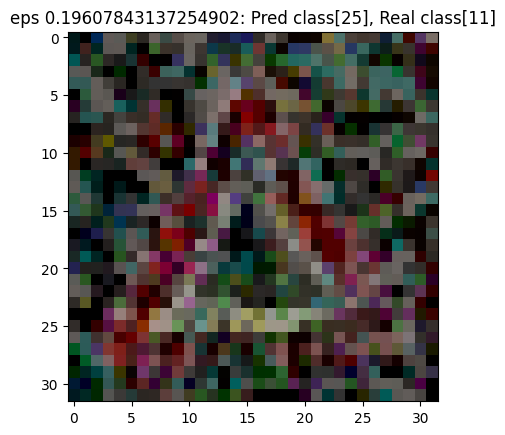

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


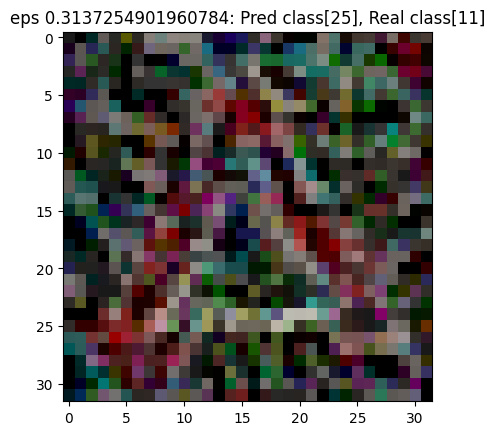

In [35]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

Ошибка предсказания произошла при значении eps 3/255.

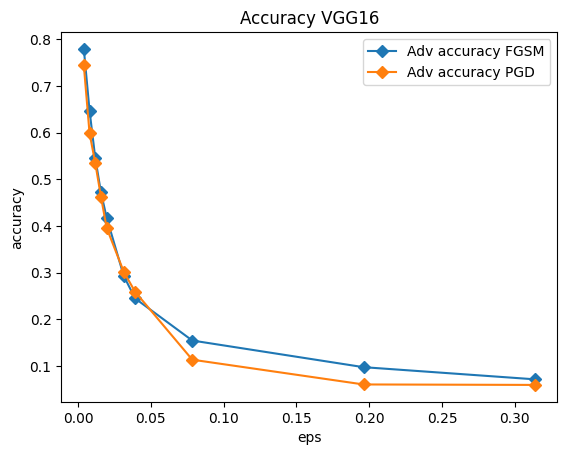

In [36]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

В случае VGG6, при атаках PGD и FGSM точность сначала падает одинаково, но с повышением значений eps в какой-то момент точнотсть при атаке PGD начинает падать сильнее, но при максимальном значении eps точность сильнее всего упала при атаке FGSM.

In [37]:
# eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# создадим таблицу со значениями точности для обеих моделей
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             97.9924 |          62.6 |          47.9 |          37.9 |          31.2 |          27.1 |          18.5 |           15.7 |            8.4 |            5.4 |            3.8 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

Таким образом была отражена таблица для всех показанных атак и моделей.
По таблице видно, что точность выше при всех значениях eps у модели VGG16.

Задание 3

Создадим две целевых атаки

Загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14

Преобразуем изображения в массив чисел и нормализуем

In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

# Включаем eager execution (рекомендуется для TensorFlow 2.x)
tf.config.run_functions_eagerly(True)

# Загружаем тестовый набор данных
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

# Извлекаем изображения с меткой 14
for img in test_imgs:
    i += 1
    if labels[i] != 14:
        continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255  # Нормализация
    data.append(img_array)
    y_test.append(labels[i])

data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)  # Преобразуем метки в one-hot encoding

Реализуем целевую атаку FGSM

Сгенерируем адверсариальные примеры и оценим точность модели на них и на исходных тестовых данных

In [39]:
# Загружаем модель
model = load_model('ResNet50.h5')

# Скомпилируем модель (укажите оптимизатор и функцию потерь)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Подготавливаем целевые метки для целевой атаки
t_class = 1  # Целевой класс (например, 1)
t_class = to_categorical(t_class, 43)  # Преобразуем в one-hot encoding
t_classes = np.tile(t_class, (data.shape[0], 1))  # Создаем массив целевых меток

# Создаём классификатор ART
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=43,  # Укажите количество классов
    input_shape=(32, 32, 3),  # Укажите форму входных данных
    clip_values=(np.min(data), np.max(data)),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

# Создаём целевую атаку FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)

# Диапазон значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

# Проводим атаку для каждого значения eps
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")

    # Генерируем adversarial examples
    x_test_adv = attack_fgsm.generate(data, t_classes)

    # Оцениваем модель на adversarial examples
    loss, accuracy = model.evaluate(x_test_adv, y_test, verbose=0)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")

    # Оцениваем модель на оригинальных данных
    loss, accuracy = model.evaluate(data, y_test, verbose=0)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Adv Loss: 0.3266018331050873
Adv Accuracy: 0.9296296238899231
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.00784313725490196
Adv Loss: 1.4871444702148438
Adv Accuracy: 0.7518518567085266
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.011764705882352941
Adv Loss: 2.7491140365600586
Adv Accuracy: 0.5740740895271301
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.01568627450980392
Adv Loss: 4.134309768676758
Adv Accuracy: 0.3888888955116272
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.0196078431372549
Adv Loss: 5.3846869468688965
Adv Accuracy: 0.23333333432674408
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.03137254901960784
Adv Loss: 7.593392848968506
Adv Accuracy: 0.051851850003004074
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.0392156862745098
Adv Loss: 8.230037689208984
Adv Accuracy: 0.018518518656492233
True Loss: 0.015207

In [40]:
eps = 10 / 255
attack_fgsm.set_params(**{'eps': eps})

# Убедимся, что t_classes имеет ту же форму, что и x_test
t_classes = np.tile(t_class, (x_test.shape[0], 1))  # Используем количество примеров в x_test

# Генерируем adversarial examples
x_test_adv = attack_fgsm.generate(x_test, t_classes)

Отобразим 5 разных изображений для визуализации действия атаки

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


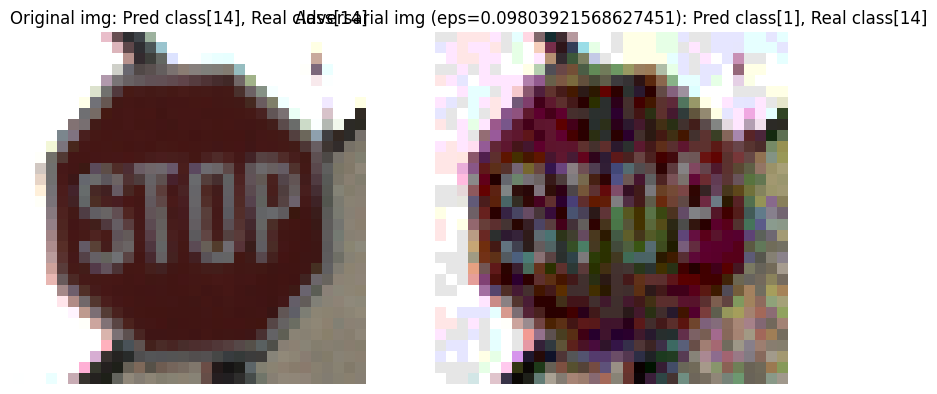

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


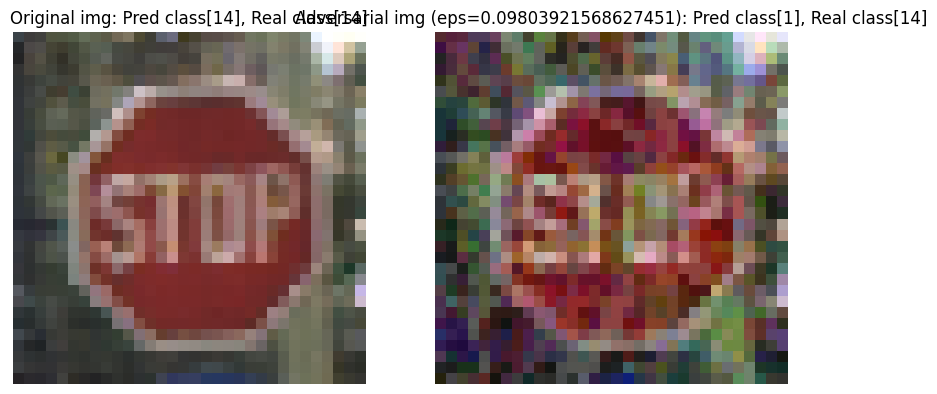

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


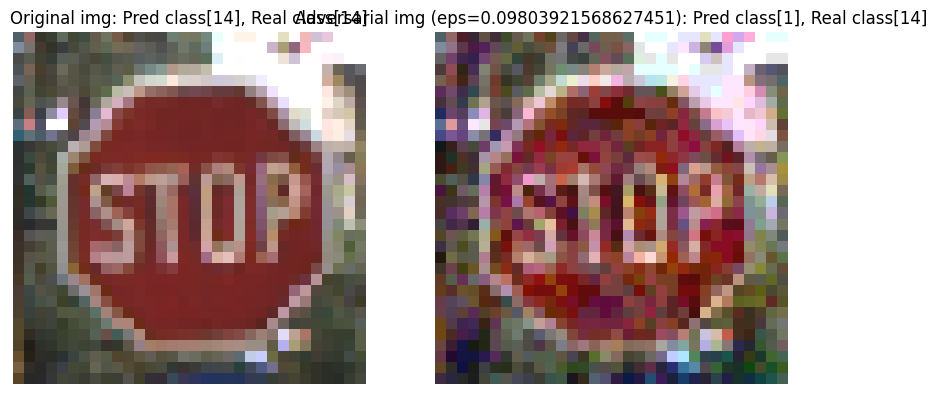

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


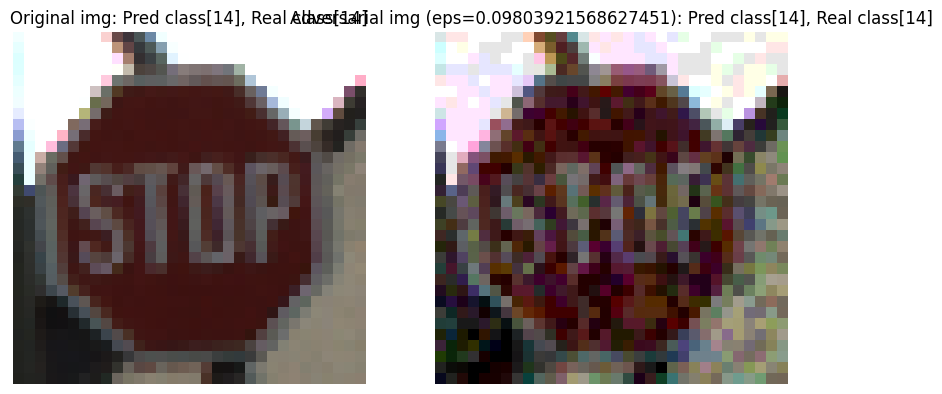

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


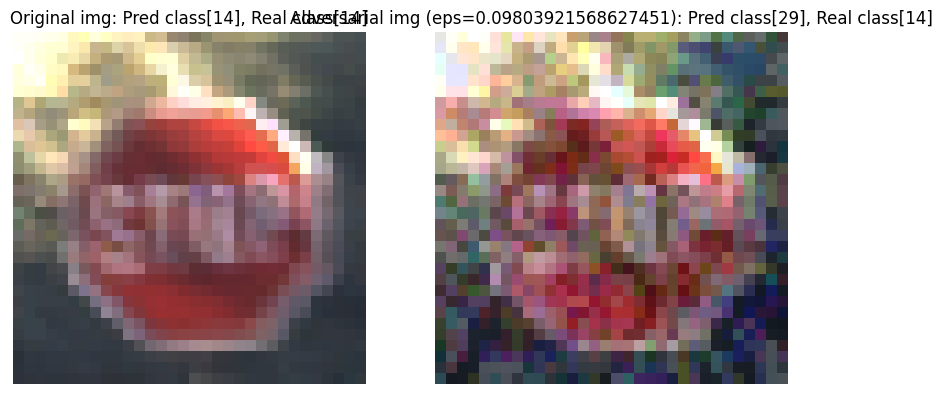

In [59]:
# Диапазон индексов для отображения
indices = [0, 10, 20, 30, 40]

# Отображаем оригинальные и атакованные изображения
for i, index in enumerate(indices):
    # Оригинальное изображение
    plt.figure(figsize=(10, 5))

    # Предсказание для оригинального изображения
    pred_original = np.argmax(model.predict(data[index:index+1]))
    plt.subplot(1, 2, 1)
    plt.imshow(data[index])  # Отображаем оригинальное изображение
    plt.title(f"Original img: Pred class[{pred_original}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    # Предсказание для атакованного изображения
    pred_adv = np.argmax(model.predict(x_test_adv[index:index+1]))
    plt.subplot(1, 2, 2)
    plt.imshow(x_test_adv[index])  # Отображаем атакованное изображение
    plt.title(f"Adversarial img (eps={eps}): Pred class[{pred_adv}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    plt.show()

Целевая атака FGSM достигает своего пика на eps = 10/255 в нашем случе, при больших значениях eps атака хоть и будет давать больше неточности при предсказании, но это будут разные классы, в большинстве случаев отличные от первого (знак стоп), который мы указали. Можно сделать вывод, что FGSM не очень подходит для целевых атак.

Реализуем целевую атаку PGD

Сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных примерах и на исходных тестовых данных

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

# Включаем eager execution (рекомендуется для TensorFlow 2.x)
tf.config.run_functions_eagerly(True)

# Загружаем тестовый набор данных
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()

# Извлекаем изображения с меткой 14
for i, img in enumerate(test_imgs):
    if labels[i] == 14:  # Фильтруем только изображения с меткой 14
        img = image.load_img(img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255  # Нормализация
        data.append(img_array)
        y_test.append(labels[i])

# Преобразуем данные в массивы NumPy
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)  # Преобразуем метки в one-hot encoding

# Загружаем модель
model = load_model('ResNet50.h5')

# Скомпилируем модель (оптимизатор и функция потерь)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Убедимся, что x_test и y_test содержат одинаковое количество примеров
assert data.shape[0] == y_test.shape[0], "x_test и y_test должны содержать одинаковое количество примеров"

# классификатор ART
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=43,  # количество классов
    input_shape=(32, 32, 3),  # форма входных данных
    clip_values=(np.min(data), np.max(data)),
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

# Подготавливаем целевые метки для целевой атаки
t_class = 1  # Целевой класс (например, 1)
t_class = to_categorical(t_class, 43)  # Преобразуем в one-hot encoding
t_classes = np.tile(t_class, (data.shape[0], 1))  # Создаем массив целевых меток

# целевая атака PGD
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)

# Диапазон значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

# Проводим атаку для каждого значения eps
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")

    # Генерируем adversarial examples
    x_test_adv = attack_pgd.generate(data, t_classes)

    # Оцениваем модель на adversarial examples
    loss, accuracy = model.evaluate(x_test_adv, y_test, verbose=0)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")

    # Оцениваем модель на оригинальных данных
    loss, accuracy = model.evaluate(data, y_test, verbose=0)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Adv Loss: 0.12406982481479645
Adv Accuracy: 0.9777777791023254
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.00784313725490196
Adv Loss: 0.4914362132549286
Adv Accuracy: 0.9074074029922485
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.011764705882352941
Adv Loss: 1.1531200408935547
Adv Accuracy: 0.7814815044403076
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.01568627450980392
Adv Loss: 1.7145211696624756
Adv Accuracy: 0.699999988079071
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.0196078431372549
Adv Loss: 1.8635162115097046
Adv Accuracy: 0.6592592597007751
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.03137254901960784
Adv Loss: 1.971389889717102
Adv Accuracy: 0.6888889074325562
True Loss: 0.015207997523248196
True Accuracy: 0.9962962865829468
Eps: 0.0392156862745098
Adv Loss: 1.9895455837249756
Adv Accuracy: 0.7111111283302307
True Loss: 0.015207997

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Устанавливаем значение eps
eps = 10 / 255
attack_pgd.set_params(**{'eps': eps})

# Генерируем adversarial examples
x_test_adv = attack_pgd.generate(data, t_classes)

Отобразим 5 разных изображений для визуализации действия атаки, также повторим атаку при eps = 25 / 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


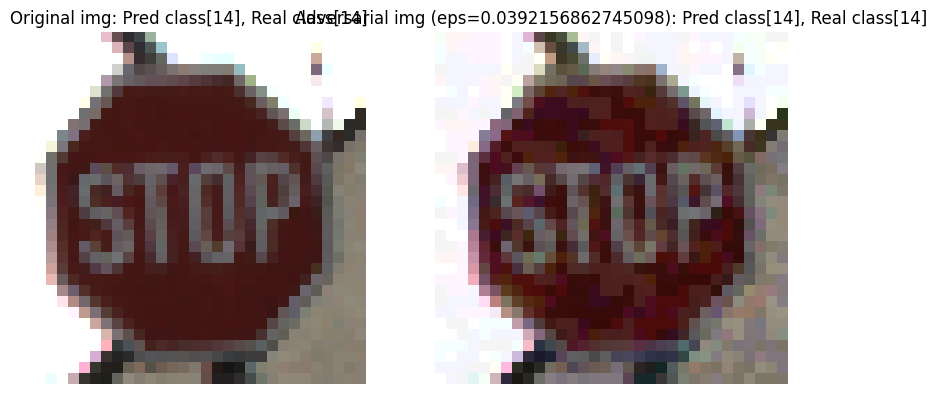

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


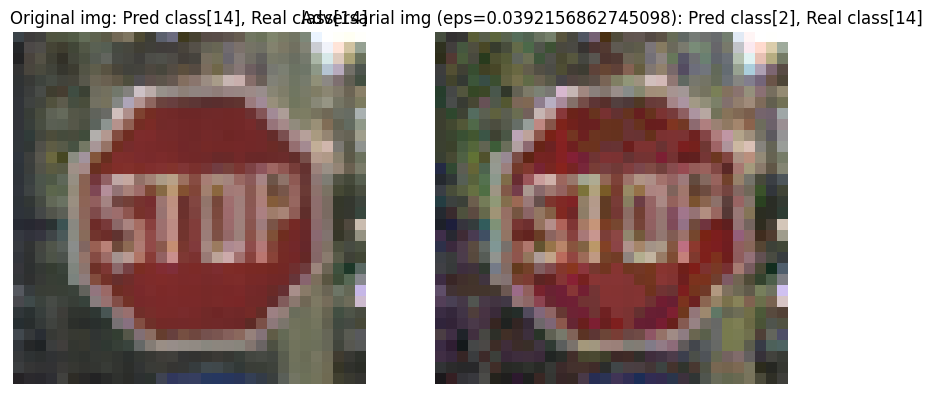

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


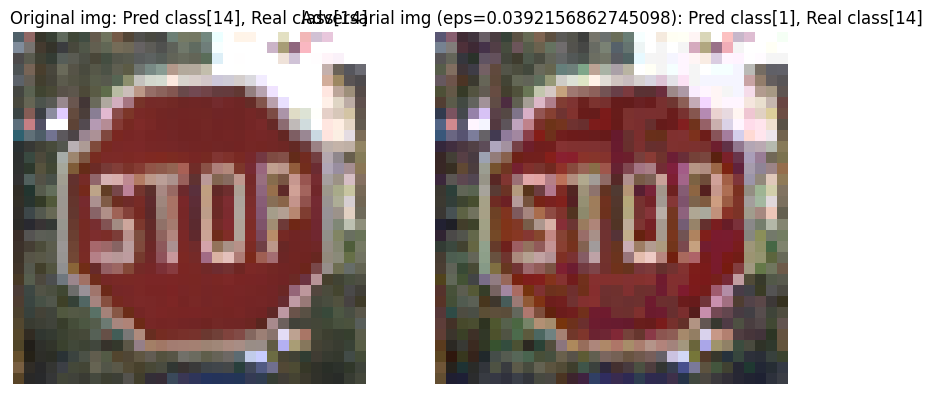

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


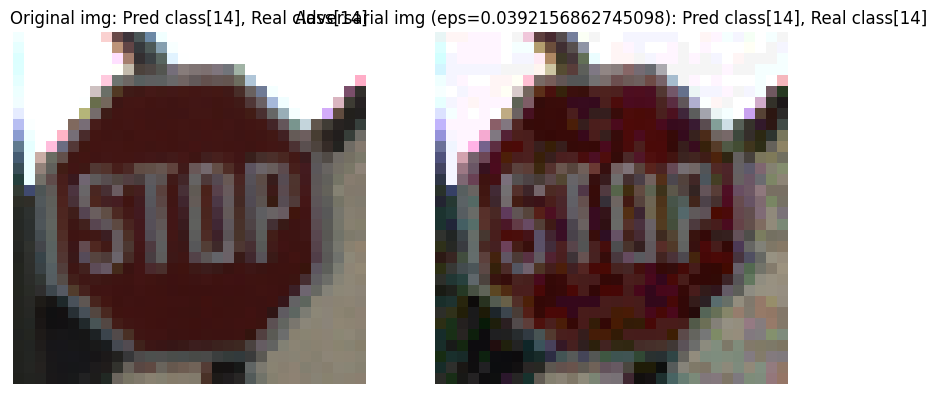

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


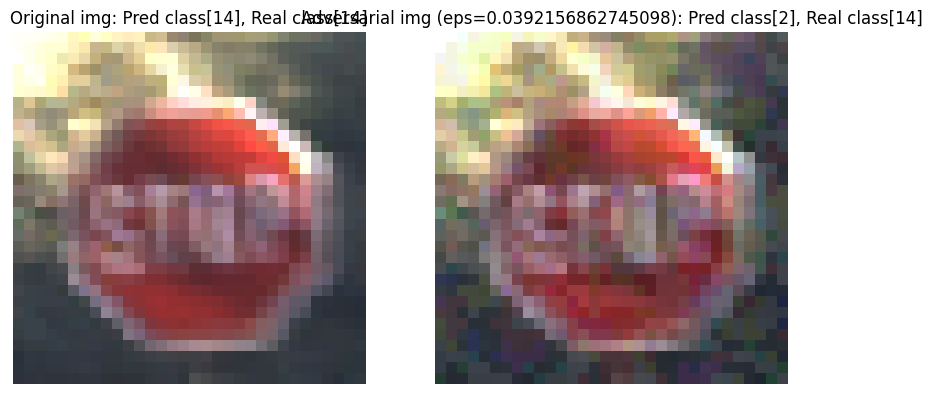

In [56]:
# Диапазон индексов для отображения
indices = [0, 10, 20, 30, 40]

# Отображаем оригинальные и атакованные изображения
for i, index in enumerate(indices):
    # Оригинальное изображение
    plt.figure(figsize=(10, 5))

    # Предсказание для оригинального изображения
    pred_original = np.argmax(model.predict(data[index:index+1]))
    plt.subplot(1, 2, 1)
    plt.imshow(data[index])  # Отображаем оригинальное изображение
    plt.title(f"Original img: Pred class[{pred_original}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    # Предсказание для атакованного изображения
    pred_adv = np.argmax(model.predict(x_test_adv[index:index+1]))
    plt.subplot(1, 2, 2)
    plt.imshow(x_test_adv[index])  # Отображаем атакованное изображение
    plt.title(f"Adversarial img (eps={eps}): Pred class[{pred_adv}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


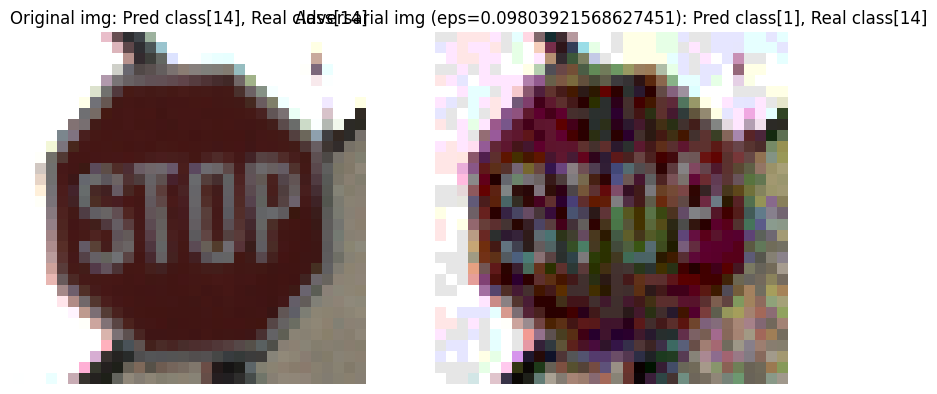

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


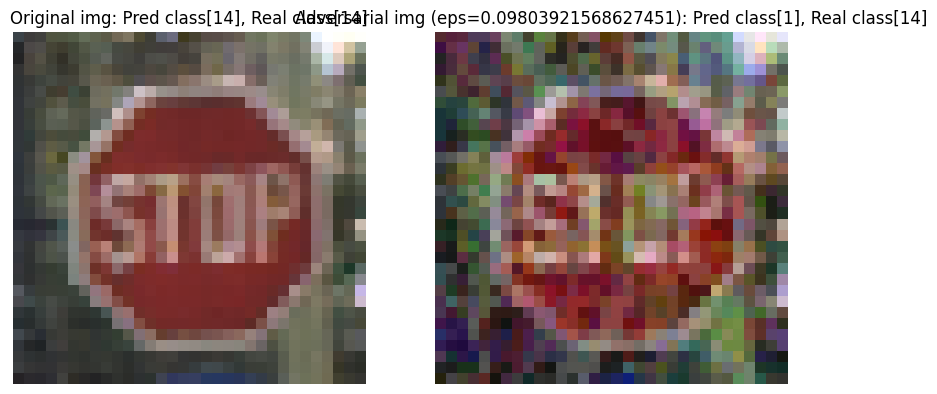

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


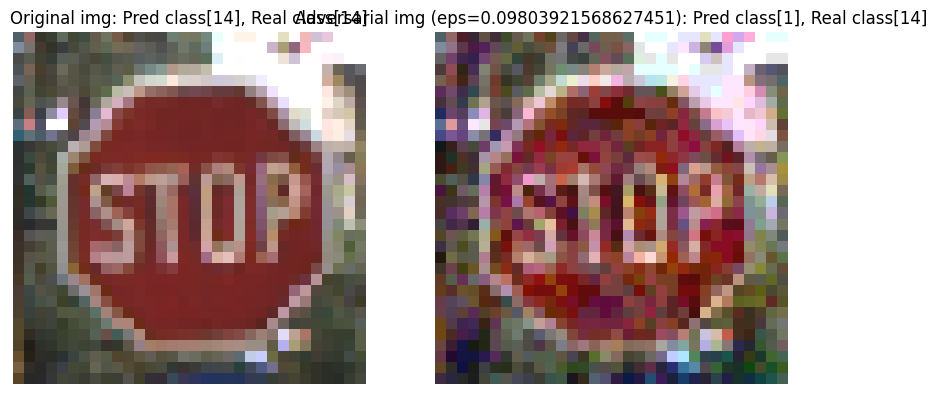

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


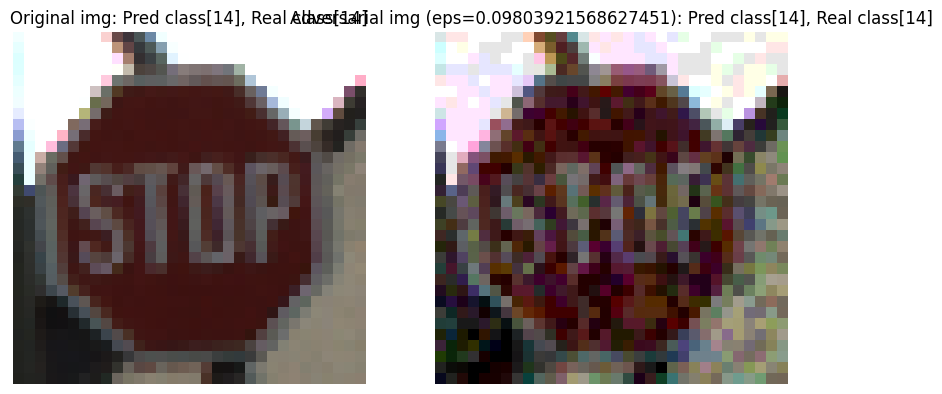

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


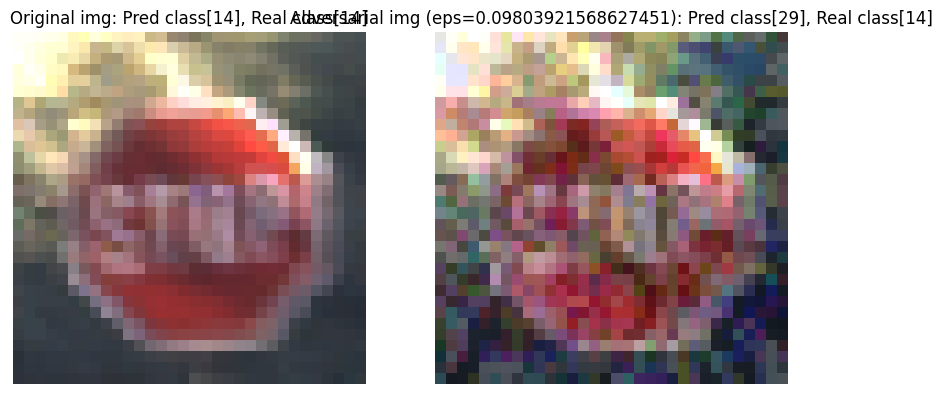

In [58]:
# Устанавливаем значение eps
eps = 25 / 255
attack_pgd.set_params(**{'eps': eps})

# Генерируем adversarial examples
x_test_adv = attack_pgd.generate(data, t_classes)

# Диапазон индексов для отображения
indices = [0, 10, 20, 30, 40]

# Отображаем оригинальные и атакованные изображения
for i, index in enumerate(indices):
    # Оригинальное изображение
    plt.figure(figsize=(10, 5))

    # Предсказание для оригинального изображения
    pred_original = np.argmax(model.predict(data[index:index+1]))
    plt.subplot(1, 2, 1)
    plt.imshow(data[index])  # Отображаем оригинальное изображение
    plt.title(f"Original img: Pred class[{pred_original}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    # Предсказание для атакованного изображения
    pred_adv = np.argmax(model.predict(x_test_adv[index:index+1]))
    plt.subplot(1, 2, 2)
    plt.imshow(x_test_adv[index])  # Отображаем атакованное изображение
    plt.title(f"Adversarial img (eps={eps}): Pred class[{pred_adv}], Real class[{np.argmax(y_test[index])}]")
    plt.axis('off')

    plt.show()

Атака PGD демонстрирует высокую эффективность при значении `eps = 10/255`, достигая значительного количества требуемых результатов (класс 1 — знак "стоп").

Как видно из результатов, атака PGD сохраняет точность на более высоком уровне по сравнению с FGSM, особенно на больших значениях `eps`. Это делает PGD более подходящей для целевых атак, так как она обеспечивает лучшие результаты на больших уровнях возмущения, чем FGSM.